In [1]:
import sys
import os

sys.path.insert(0, "..")

import csv
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import partial
from datetime import datetime
from torchvision import transforms

from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data import collate_data_and_cast, DataAugmentationDINO, MaskingGenerator
import dinov2.distributed as distributed

/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submi

In [2]:
train_ds_path = "HDF5Dataset:split=TRAIN:root=/home/jluesch/Documents/data/plankton/2007-TRAIN.hdf5:extra=*"
train_ds_path = "LMDBDataset:split=TRAIN:root=/home/jluesch/Documents/data/plankton/lmdb/2007-TRAIN:extra=*"

img_size = 224
patch_size = 14
n_tokens = (img_size // patch_size) ** 2
inputs_dtype = torch.half
do_on_gpu = True
do_data_aug = False

mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

if not do_on_gpu and do_data_aug:
    data_transform = DataAugmentationDINO(
        (0.32, 1.0),
        (0.05, 0.32),
        8,
        global_crops_size=224,
        local_crops_size=96,
    )
    data_transform_gpu = None
elif do_data_aug:
    data_transform_cpu = transforms.ToTensor()
    data_transform_gpu = DataAugmentationDINO(
        (0.32, 1.0),
        (0.05, 0.32),
        8,
        global_crops_size=224,
        local_crops_size=96,
        do_transform_on_gpu=True,
    )
else:
    data_transform_cpu = transforms.ToTensor()
    data_transform_gpu = None

collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=(0.1, 0.5),
    mask_probability=0.5,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
)

# setup data loader
dataset = make_dataset(
    dataset_str=train_ds_path,
    transform=data_transform_cpu,
    target_transform=lambda _: (),
)

print(f"#samples: {len(dataset)}")

Dataset kwargs {'split': <_Split.TRAIN: 'train'>, 'root': '/home/jluesch/Documents/data/plankton/lmdb/2007-TRAIN', 'extra': '*'}
extra_full_path /home/jluesch/Documents/data/plankton/lmdb/2007-TRAIN_*
Datasets imgs file list:  ['/home/jluesch/Documents/data/plankton/lmdb/2007-TRAIN_imgs']
Datasets labels file list:  ['/home/jluesch/Documents/data/plankton/lmdb/2007-TRAIN_labels']
lmdb_env_labels.stat() {'psize': 4096, 'depth': 3, 'branch_pages': 18, 'leaf_pages': 2427, 'overflow_pages': 0, 'entries': 289020}
lmdb_env_imgs.stat() {'psize': 4096, 'depth': 4, 'branch_pages': 511, 'leaf_pages': 68809, 'overflow_pages': 192250, 'entries': 289020}
#unique_class_ids: _Split.TRAIN, 88
#samples: 289020


In [3]:
batch_size_list = [32, 64, 128, 256, 512]
num_workers_list = [2, 4, 8, 16, 32]
MAX_NB_SAMPLE = 50000
verbose = False
erase_preexisting_entries = False

res_file_path = f"./dataloader_benchmark_results_{MAX_NB_SAMPLE}_gpu{do_on_gpu}_dataaug{do_data_aug}_lmdb.csv"

if erase_preexisting_entries:
    with open(res_file_path, "w", newline="") as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=",")
        csvwriter.writerow(
            [
                "batch_size",
                "num_workers",
                "tot_time",
                "mean_batch",
                "std_batch",
                "min_batch",
                "max_batch",
                "nb_iters",
                "MAX_NB_SAMPLE",
                "do_data_aug",
            ]
        )

with open(res_file_path, "a", newline="") as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=",")

    for num_workers in num_workers_list:
        for batch_size in batch_size_list:
            # sampler_type = SamplerType.INFINITE
            sampler_type = SamplerType.SHARDED_INFINITE
            if not do_on_gpu:
                data_loader = make_data_loader(
                    dataset=dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                    seed=0,
                    sampler_type=sampler_type,
                    sampler_advance=0,  # TODO(qas): fix this -- start_iter * cfg.train.batch_size_per_gpu,
                    drop_last=True,
                    collate_fn=collate_fn,
                )
            else:
                data_loader = make_data_loader(
                    dataset=dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                    seed=0,  # TODO: Fix this -- cfg.train.seed
                    sampler_type=sampler_type,
                    sampler_advance=0,  # TODO(qas): fix this -- start_iter * cfg.train.batch_size_per_gpu,
                    drop_last=True,
                    collate_fn=None,
                )

            start_t = datetime.now().timestamp()

            batch_delta_ts = []
            batch_start_t = datetime.now().timestamp()
            for i, data in enumerate(data_loader):
                if data_transform_gpu is not None:
                    # current_device_nb = model.student.backbone.device
                    if isinstance(data, list):
                        data = data[0].to(device=f"cuda:{torch.cuda.current_device()}")

                    data = data_transform_gpu(data)
                    data = collate_fn(data)  # collate_fn collates crops and computes masks tensors
                    # TODO: teacher crops are not used????

                    data = {
                        k: (
                            v.to(device=f"cuda:{torch.cuda.current_device()}")
                            if torch.is_tensor(v) and not v.is_cuda
                            else v
                        )
                        for k, v in data.items()
                    }
                batch_end_t = datetime.now().timestamp()

                batch_delta_t = batch_end_t - batch_start_t
                batch_delta_ts.append(batch_delta_t)

                if verbose or i % 100 == 0:
                    print(f"{i}, {i*batch_size}: {batch_delta_t:.5}")
                if verbose:
                    print(data["collated_masks"].shape)
                    print(data["mask_indices_list"].shape)
                    print(data["masks_weight"].shape)
                    print(data["upperbound"], data["n_masked_patches"])

                batch_start_t = datetime.now().timestamp()

                if i * batch_size >= MAX_NB_SAMPLE:
                    end_t = datetime.now().timestamp()
                    break

            total_t = end_t - start_t
            mean_batch = np.mean(batch_delta_ts[2:])  # remove first 2 steps
            std_batch = np.std(batch_delta_ts[2:])
            max_batch = np.max(batch_delta_ts[2:])
            min_batch = np.min(batch_delta_ts[2:])
            print(f"BATCH SIZE {batch_size}, NUM WORKERS {num_workers}, TIME TOTAL: {total_t:.5}")
            print(f"PER BATCH: {mean_batch:.5} ± {std_batch:.5}, max {max_batch:.5}, min {min_batch:.5}")
            print(
                f"TIME PER SAMPLE: {mean_batch/batch_size:.5} ± {std_batch/batch_size:.5}, max {max_batch/batch_size:.5}, min {min_batch/batch_size:.5}"
            )
            print()
            csvwriter.writerow(
                [batch_size, num_workers, total_t, mean_batch, std_batch, min_batch, max_batch, i, MAX_NB_SAMPLE]
            )
            csvfile.flush()

0, 0: 3.1762
100, 3200: 0.035866
200, 6400: 0.037996
300, 9600: 0.030236
400, 12800: 0.032986
500, 16000: 0.039331
600, 19200: 0.035114
700, 22400: 0.037118
800, 25600: 0.034238
900, 28800: 0.034408
1000, 32000: 0.03465
1100, 35200: 0.037841
1200, 38400: 0.037299
1300, 41600: 0.047874
1400, 44800: 0.033159
1500, 48000: 0.036865
BATCH SIZE 32, NUM WORKERS 2, TIME TOTAL: 31.483
PER BATCH: 0.01811 ± 0.017922, max 0.084134, min 0.00012994
TIME PER SAMPLE: 0.00056594 ± 0.00056005, max 0.0026292, min 4.0606e-06

0, 0: 2.2625
100, 6400: 0.016704
200, 12800: 0.043732
300, 19200: 0.016804
400, 25600: 0.00020313
500, 32000: 0.00019908
600, 38400: 0.00020909
700, 44800: 0.00020003
BATCH SIZE 64, NUM WORKERS 2, TIME TOTAL: 26.885
PER BATCH: 0.031451 ± 0.025979, max 0.089683, min 0.00015688
TIME PER SAMPLE: 0.00049142 ± 0.00040592, max 0.0014013, min 2.4512e-06

0, 0: 2.4617
100, 12800: 0.12295
200, 25600: 0.12608
300, 38400: 0.09543
BATCH SIZE 128, NUM WORKERS 2, TIME TOTAL: 27.231
PER BATCH: 0.06

In [11]:


timing_df = pd.read_csv(res_file_path)

timing_df = timing_df[['batch_size', 'num_workers', 'tot_time']]

timing_df.set_index(['batch_size', 'num_workers'])


,,tot_time
batch_size,num_workers,
32,8,18.296959
64,8,17.897950
128,8,18.130205
256,8,17.617762
512,8,17.816417
32,16,18.810465
64,16,19.432258
128,16,18.494297
256,16,17.326411


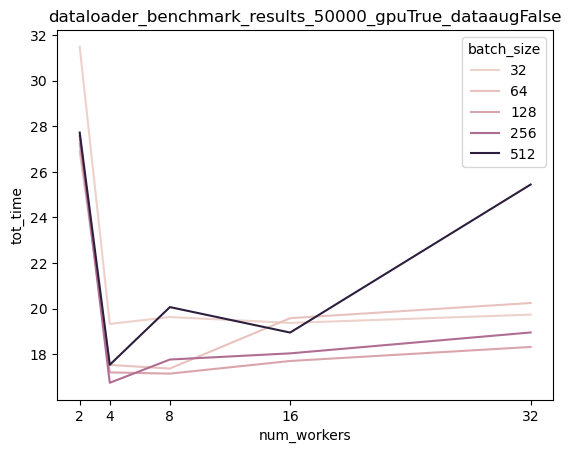

In [10]:
sns.lineplot(timing_df, x="num_workers", y="tot_time", hue="batch_size")
plt.xticks(timing_df["num_workers"].unique())

os.makedirs(res_file_path[:-4] + "lmdb", exist_ok=True)
save_fig_path = os.path.join(res_file_path[:-4] + "lmdb", "time_vs_num_workers_workstation.png")
plt.title(res_file_path[2:-4])
plt.savefig(save_fig_path, dpi=300)
plt.show()